# cNMF analysis for TF full dataset
## choosing K
## Identifying different programs for cardiomyocyte development

* Paper: https://elifesciences.org/articles/43803
* Tutorial: https://github.com/dylkot/cNMF/blob/master/Tutorials/analyze_pbmc_example_data.ipynb

In [1]:
#!/usr/bin/env python3
import os
import re
import sys
print(sys.executable)
print(sys.path)
print(sys.version)

import collections
import argparse
#import tables
import itertools
import matplotlib
import glob
import math
%matplotlib inline

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scanpy as sc 
import scanpy.external as sce
from cnmf import cNMF

from collections import defaultdict
from scipy import sparse, io

#from matplotlib_venn import venn2, venn2_circles
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('matplotlib', matplotlib.__version__)
print('scanpy', sc.__version__)

/home2/s438217/.conda/envs/new_scanpy/bin/python3.10
['', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/home2/s438217/.conda/envs/new_scanpy/lib/python310.zip', '/home2/s438217/.conda/envs/new_scanpy/lib/python3.10', '/home2/s438217/.conda/envs/new_scanpy/lib/python3.10/lib-dynload', '/home2/s438217/.conda/envs/new_scanpy/lib/python3.10/site-packages']
3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
numpy 1.26.4
pandas 2.2.3
scipy 1.11.4
matplotlib 3.9.2
scanpy 1.10.3


In [2]:
import pickle
import seaborn as sns

import gseapy as gp
from gseapy import Msigdb
import requests


# evaluating different K's 
### details of the run 100 iterations
### highly variable genes - 2000
### K = [5,6,7,8,9,10,11,12,13,14,15,17,19,21,23,25,27,30,35,40,45,50,55,60,70,80,90,100]

## loading the files

In [3]:
output_directory = '/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
run_name = 'tf_perturb'
cnmf_obj = cNMF(output_dir=output_directory, name=run_name)
K_values = [5,6,7,8,9,10,11,12,13,14,15,17,19,21,23,25,27,30,35,40,45,50,55,60,70,80,90,100,150,200,250,500]
density_threshold = 0.1



In [4]:
# New function from version 1.4
def load_results(self, K, density_threshold, n_top_genes=300):
        """
        Loads normalized usages and gene_spectra_scores for a given choice of K and 
        local_density_threshold for the cNMF run. Additionally returns a DataFrame of
        the top genes linked to each program with the number of genes indicated by the
        `n_top_genes` parameter

        Returns
        usage - cNMF usages (cells X K) normalized to sum to 1
        spectra - Z-score regressed coeffecients for each program (K x genes) with higher values cooresponding
                    to better marker genes
        top_genes - ranked list of marker genes per GEP (n_top_genes X K)
        """
        scorefn = self.paths['gene_spectra_score__txt'] % (K, str(density_threshold).replace('.', '_'))
        tpmfn = self.paths['gene_spectra_tpm__txt'] % (K, str(density_threshold).replace('.', '_'))
        usagefn = self.paths['consensus_usages__txt'] % (K, str(density_threshold).replace('.', '_'))
        spectra_scores = pd.read_csv(scorefn, sep='\t', index_col=0).T
        spectra_tpm = pd.read_csv(tpmfn, sep='\t', index_col=0).T

        usage = pd.read_csv(usagefn, sep='\t', index_col=0)
        usage = usage.div(usage.sum(axis=1), axis=0)

        try:
            usage.columns = [int(x) for x in usage.columns]
        except:
            print('Usage matrix columns include non integer values')

        top_genes = []
        for gep in spectra_scores.columns:
            top_genes.append(list(spectra_scores.sort_values(by=gep, ascending=False).index[:n_top_genes]))

        top_genes = pd.DataFrame(top_genes, index=spectra_scores.columns).T
        return(usage, spectra_scores, spectra_tpm, top_genes)

In [5]:
cNMF_output_dict_all_Ks = {}

# Iterate over each K value
for K in K_values:
    usage_norm, gep_scores, gep_tpm, topgenes = load_results(cnmf_obj, K=K, density_threshold=density_threshold)
    
    # Rename the columns of usage_norm
    usage_norm.columns = ['Usage_%d' % i for i in usage_norm.columns]
    
    # Store the results in the dictionary with dynamic keys
    cNMF_output_dict_all_Ks[f'usage_norm_k_{K}'] = usage_norm
    cNMF_output_dict_all_Ks[f'gep_scores_k_{K}'] = gep_scores
    cNMF_output_dict_all_Ks[f'gep_tpm_k_{K}'] = gep_tpm
    cNMF_output_dict_all_Ks[f'topgenes_k_{K}'] = topgenes


### Assessing perturbation sensitivity by comparing mean usage score of targeting cells  with non-targeting cells

In [6]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests




In [ ]:


def compare_scores(usage_norm_k, cell_gRNA):
    """
    Compare scores between non-targeting rows and rows where other genes are active (value 1),
    as well as comparing non-targeting rows with themselves, and calculate log2 fold change.
    
    Parameters:
    usage_norm_k (pd.DataFrame): DataFrame containing score columns.
    cell_gRNA (pd.DataFrame): DataFrame containing binary indicators (0 or 1).
    
    Returns:
    pd.DataFrame: A DataFrame containing the results of the Mann-Whitney U tests and log2 fold changes.
    """
    # Create a list to store results
    results = []

    # Get the indices of rows where 'non-targeting' is 1 in cell_gRNA
    non_targeting_rows = cell_gRNA.index[cell_gRNA['non-targeting'] == 1]

    # Loop over all score columns in usage_norm_k
    for score_col in usage_norm_k.columns:
        # Compare non-targeting with itself
        scores_non_targeting_self = usage_norm_k.loc[non_targeting_rows, score_col]
        stat_self, p_value_self = mannwhitneyu(scores_non_targeting_self, scores_non_targeting_self, alternative='two-sided')
        
        # Store self-comparison results
        results.append({
            'Gene': 'non-targeting (self)',
            'Score Column': score_col,
            'Statistic': stat_self,
            'p-value': p_value_self,
            'Log2 Fold Change': np.nan  # No change when comparing with itself
        })

        # Loop over each gene column in cell_gRNA
        for gene_col in cell_gRNA.columns:
            if gene_col != 'non-targeting':
                # Get indices of rows where the current gene column has value 1
                comparison_rows = cell_gRNA.index[cell_gRNA[gene_col] == 1]

                # If there are no rows in the comparison group, skip to the next gene column
                if len(comparison_rows) == 0:
                    continue

                # Extract scores for the two groups from usage_norm_k
                scores_comparison = usage_norm_k.loc[comparison_rows, score_col]

                # Perform Mann-Whitney U test
                stat, p_value = mannwhitneyu(scores_non_targeting_self, scores_comparison, alternative='two-sided')

                # Calculate log2 fold change
                mean_non_targeting = scores_non_targeting_self.mean()
                mean_comparison = scores_comparison.mean()
                
                # Avoid division by zero; use np.log2(1) for log2FC if mean is zero
                log2fc = np.log2((mean_comparison + 1e-9) / (mean_non_targeting + 1e-9))

                # Store results
                results.append({
                    'Gene': gene_col,
                    'Score Column': score_col,
                    'Statistic': stat,
                    'p-value': p_value,
                    'Log2 Fold Change': log2fc
                })

    # Create a DataFrame from results
    results_df = pd.DataFrame(results)

    # Apply Benjamini-Hochberg correction
    reject, corrected_p_values = multipletests(results_df['p-value'], method='fdr_bh')[:2]

    # Add corrected p-values to the results DataFrame
    results_df['Corrected p-value (BH)'] = corrected_p_values

    return results_df


#### THE ADATA WAS TOO BIG  RAN IT IN CLUSTER
#### THE RESULTING FILES ARE BELOW

## loading the compare score for sig perturbations

In [7]:
with open('/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/compare_score_pert_all_k_all_targets_clear_gRNA_12_3_24.pkl', 'rb') as file:
    compare_score_pert_all_ks = pickle.load(file)

In [8]:
import pandas as pd

# Initialize an empty list to store significant results
significant_results = []

# Iter ate through each DataFrame in final_results
for k, df in compare_score_pert_all_ks.items():
    if isinstance(df, pd.DataFrame):
        df["Corrected p-value (BH)"] = df["Corrected p-value (BH)"].round(4)
        # Filter for rows with corrected p-values less than 0.05
        #significant_df = df[df['Corrected p-value (BH)'] < 0.001]
        significant_df = df
        
        # If there are significant results, add them to the list with the key
        if not significant_df.empty:
            significant_df['K'] = k  # Add a column for the key
            significant_results.append(significant_df)

# Concatenate all significant DataFrames into one
if significant_results:
    significant_k = pd.concat(significant_results, ignore_index=True)
else:
    significant_k = pd.DataFrame()  # Empty DataFrame if no significant results'''




### Without any filter

In [9]:
significant_k = significant_k.sort_values(by = "Corrected p-value (BH)")

### Using  OR genes to determine p value for significance
### Determining p value that has less OR genes as hit

In [10]:
OR = significant_k[significant_k["Gene"].str.startswith("OR")]

In [11]:
p_value_0_05 = significant_k[significant_k["Corrected p-value (BH)"]<0.05]

In [12]:
p_0_0_1 = significant_k[significant_k["Corrected p-value (BH)"]<0.001]

In [13]:
significant_k =  significant_k[significant_k["Corrected p-value (BH)"]<0.001]

In [14]:
significant_k['Numeric K'] = significant_k['K'].str.extract('(\d+)').astype(int)


In [15]:
significant_k['Numeric K'] = significant_k['K'].str.extract('(\d+)').astype(int)
significant_k = significant_k.sort_values(by='Numeric K')
significant_counts = significant_k.groupby('K').size().reset_index(name='Count')
significant_counts['Numeric K'] = significant_counts['K'].str.extract('(\d+)').astype(int)
significant_counts = significant_counts.sort_values(by='Numeric K')



## unique TF per K

In [131]:
# Initialize a set to track seen genes and a result list
seen_genes = set()
result = []

# Iterate through each unique K value
for k in sorted(significant_k['Numeric K'].unique()):
    # Get the unique genes for the current K that haven't been seen yet
    current_genes = significant_k[significant_k['Numeric K'] == k]['Gene'].unique()
    unique_genes_for_k = [gene for gene in current_genes if gene not in seen_genes]
    
    # Count the unique genes
    unique_count = len(unique_genes_for_k)
    
    # Add the count to the result list
    result.append({'Numeric K': k, 'Unique Gene Count': unique_count})
    
    # Update the seen genes set
    seen_genes.update(unique_genes_for_k)

# Convert the result list to a DataFrame
result_df = pd.DataFrame(result)
result_df = result_df.iloc[:31,:]


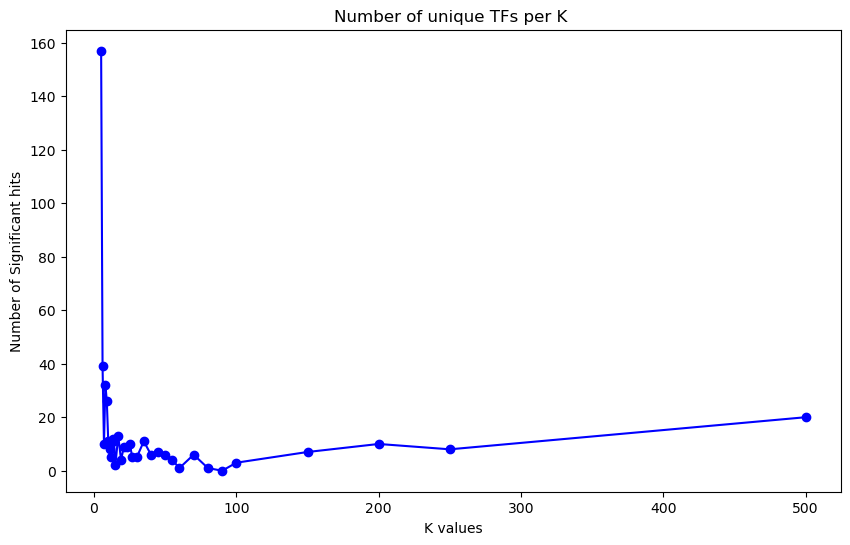

In [113]:
import matplotlib.pyplot as plt

# Prepare data for plotting
Ks = list(result_df["Numeric K"])
unique_counts = list(result_df["Unique Gene Count"])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Ks, unique_counts, marker='o', linestyle='-', color='b')
plt.title('Number of unique TFs per K ')
plt.xlabel('K values')
plt.ylabel('Number of Significant hits')
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/unique_TF_K_250_TF_full.pdf")
#plt.xticks(Ks)  # Ensure all K values are shown on the x-axis
#plt.grid()
#plt.tight_layout()
plt.show()


/tmp/ipykernel_2607/2887281189.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


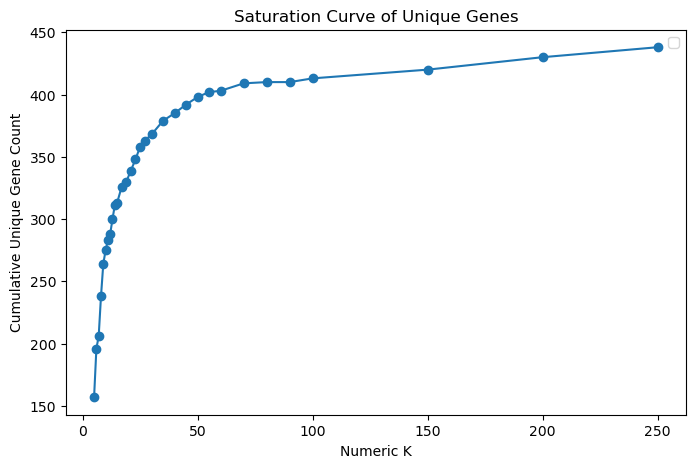

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute the cumulative sum of unique gene counts
result_df['Cumulative Unique Gene Count'] = result_df['Unique Gene Count'].cumsum()

# Plot the saturation curve
plt.figure(figsize=(8, 5))
plt.plot(result_df['Numeric K'], result_df['Cumulative Unique Gene Count'], marker='o', linestyle='-')

# Label the axes
plt.xlabel('Numeric K')
plt.ylabel('Cumulative Unique Gene Count')
plt.title('Saturation Curve of Unique Genes')

# Highlight the saturation trend
#plt.axhline(y=result_df['Cumulative Unique Gene Count'].max())
plt.legend()

# Show the plot
plt.show()


Residual at K=500: 14.19
Standardized Residual (Z-score): 1.62
IQR: 8.72, Upper Fence: 18.45, Strong Outlier Threshold: 31.53


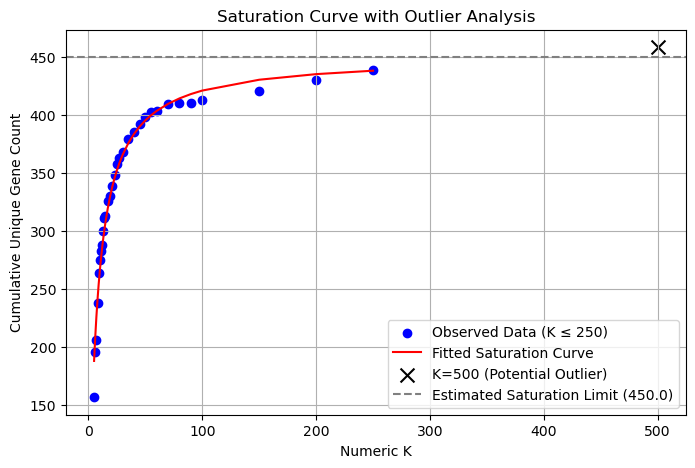

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import zscore

# Define saturation function
def saturation_curve(K, a, b):
    return (a * K) / (b + K)

# Separate trusted data (K ≤ 250) and K=500
x_train = result_df[result_df["Numeric K"] <= 250]["Numeric K"].values
y_train = result_df[result_df["Numeric K"] <= 250]["Cumulative Unique Gene Count"].values

x_test = 500
y_test = result_df[result_df["Numeric K"] == 500]["Cumulative Unique Gene Count"].values[0]

# Fit the model using K ≤ 250
params, covariance = curve_fit(saturation_curve, x_train, y_train, maxfev=5000)
a_fit, b_fit = params

# Predict value for K=500 and compute residuals
y_pred_train = saturation_curve(x_train, *params)  # Predictions for training data
y_pred_500 = saturation_curve(x_test, *params)  # Prediction for K=500

residuals_train = y_train - y_pred_train  # Residuals for K ≤ 250
residual_500 = y_test - y_pred_500  # Residual for K=500

# Standardized Residual (Z-score)
std_residuals = np.std(residuals_train)
z_score_500 = residual_500 / std_residuals

# IQR Method
q1, q3 = np.percentile(residuals_train, [25, 75])
iqr = q3 - q1
upper_fence = q3 + (1.5 * iqr)
strong_outlier_fence = q3 + (3 * iqr)

# Print results
print(f"Residual at K=500: {residual_500:.2f}")
print(f"Standardized Residual (Z-score): {z_score_500:.2f}")
print(f"IQR: {iqr:.2f}, Upper Fence: {upper_fence:.2f}, Strong Outlier Threshold: {strong_outlier_fence:.2f}")

# Determine outlier status
if abs(z_score_500) > 3:
    print("K=500 is a strong outlier based on Z-score (>|3|).")
elif abs(z_score_500) > 2:
    print("K=500 is a moderate outlier based on Z-score (>|2|).")

if residual_500 > strong_outlier_fence:
    print("K=500 is a strong outlier based on the IQR rule.")
elif residual_500 > upper_fence:
    print("K=500 is a moderate outlier based on the IQR rule.")

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, label="Observed Data (K ≤ 250)", color='blue')
plt.plot(x_train, y_pred_train, label="Fitted Saturation Curve", color='red')
plt.scatter(x_test, y_test, color='black', marker='x', s=100, label="K=500 (Potential Outlier)")
plt.axhline(y=a_fit, color='gray', linestyle='--', label=f"Estimated Saturation Limit ({a_fit:.1f})")
plt.xlabel("Numeric K")
plt.ylabel("Cumulative Unique Gene Count")
plt.title("Saturation Curve with Outlier Analysis")
plt.legend()
plt.grid(True)
plt.show()


## cooks distance to identify outliers in a dataset

Cook's Distance for K=500: 6.6650
K=500 has HIGH influence on the model (potential outlier).


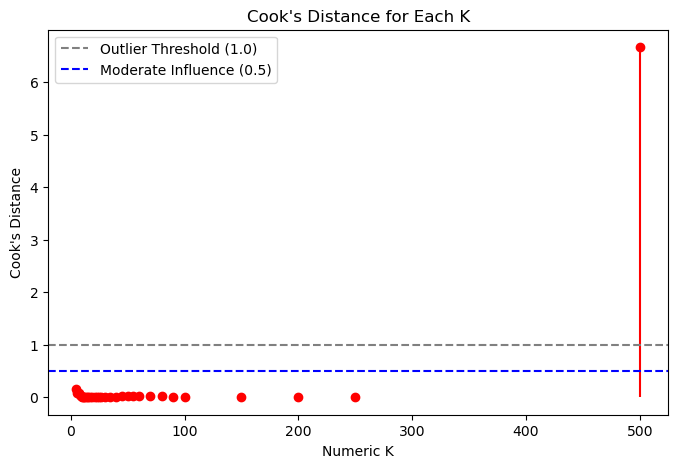

In [119]:
import statsmodels.api as sm

# Add constant for linear regression
X = sm.add_constant(result_df["Numeric K"])
y = result_df["Cumulative Unique Gene Count"]

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Compute influence measures
influence = model.get_influence()
cooks_d, _ = influence.cooks_distance  # Cook's Distance

# Extract value for K=500
cooks_500 = cooks_d[list(result_df["Numeric K"]).index(500)]

# Print results
print(f"Cook's Distance for K=500: {cooks_500:.4f}")

# Interpretation
if cooks_500 > 1:
    print("K=500 has HIGH influence on the model (potential outlier).")
elif cooks_500 > 0.5:
    print("K=500 has MODERATE influence on the model.")
else:
    print("K=500 has LOW influence on the model.")

# Plot Cook's Distance
plt.figure(figsize=(8, 5))
plt.stem(result_df["Numeric K"], cooks_d, markerfmt="ro", linefmt="r-", basefmt=" ")
plt.axhline(1, color="gray", linestyle="--", label="Outlier Threshold (1.0)")
plt.axhline(0.5, color="blue", linestyle="--", label="Moderate Influence (0.5)")
plt.xlabel("Numeric K")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each K")
plt.legend()
plt.show()


In [130]:
cooks_d

array([1.56328655e-01, 8.93268239e-02, 7.51517555e-02, 3.84854376e-02,
       1.78167241e-02, 1.15540288e-02, 7.90944333e-03, 6.03890422e-03,
       2.49711855e-03, 6.17422301e-04, 4.46376202e-04, 5.19409180e-05,
       2.02867838e-04, 1.06511703e-03, 2.57471575e-03, 5.01799738e-03,
       6.31104186e-03, 7.50192985e-03, 1.08599162e-02, 1.22634440e-02,
       1.42797646e-02, 1.59444761e-02, 1.66619173e-02, 1.58595024e-02,
       1.66739507e-02, 1.51678407e-02, 1.34616057e-02, 1.35099506e-02,
       1.04247299e-02, 7.26415321e-03, 1.16437097e-03, 6.66501207e+00])

In [31]:
seen_genes = set()
result = []
last_k_unique_genes = []  # To store unique genes for the last K

# Iterate through each unique K value
for k in sorted(significant_k['Numeric K'].unique()):
    # Get the unique genes for the current K that haven't been seen yet
    current_genes = significant_k[significant_k['Numeric K'] == k]['Gene'].unique()
    unique_genes_for_k = [gene for gene in current_genes if gene not in seen_genes]
    
    # Count the unique genes
    unique_count = len(unique_genes_for_k)
    
    # Add the count to the result list
    result.append({'Numeric K': k, 'Unique Gene Count': unique_count})
    
    # If it's the last K, store the unique genes
    if k == sorted(significant_k['Numeric K'].unique())[-1]:
        last_k_unique_genes = unique_genes_for_k
    
    # Update the seen genes set
    seen_genes.update(unique_genes_for_k)

# Convert the result list to a DataFrame
result_df = pd.DataFrame(result)

## Gene ontology term evaluation
## recovering unique GO terms for every K at seeing where they saturate

### gene by program matrix
### top N Genes

In [32]:
import pandas as pd

# Assume cNMF_output_dict_all_Ks is already defined and contains your data
top_genes_dict = {}

# Loop through each K value
for K in K_values:
    gep_zscore = cNMF_output_dict_all_Ks[f"gep_scores_k_{K}"]  # Access the DataFrame directly
    top_genes = []
    ngenes = 300
    
    for gep in gep_zscore.columns:
        # Sort and get the top genes
        top_genes.append(list(gep_zscore.sort_values(by=gep, ascending=False).index[:ngenes]))
    
    # Store the result in a dictionary with K as the key
    top_genes_dict[K] = pd.DataFrame(top_genes, index=gep_zscore.columns).T

# Now top_genes_dict contains top genes for each K


## Gene ontology file - this was run on cluster and the resulting file used

In [33]:
with open('/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/TF_full_GO_all_enriched_results.pkl', 'rb') as file:
    enrichment_results = pickle.load(file)
    


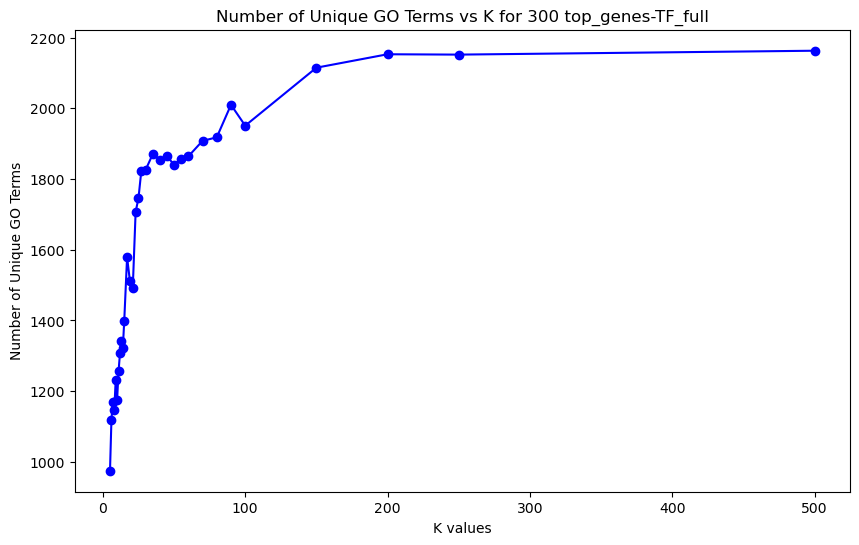

In [34]:

# Assuming you have a dictionary of DataFrames `dfs_dict`
filtered_dict = {}

# Loop through each key-value pair in the original dictionary
for key, df in enrichment_results.items():
    # Check if the adjusted p-value column exists
    if 'Adjusted P-value' in df.columns:
        # Filter rows where the adjusted p-value is less than 0.05
        filtered_df = df[df['Adjusted P-value'] < 0.05]
        
        # Store the filtered DataFrame in the new dictionary
        filtered_dict[key] = filtered_df

# Now filtered_dict contains the filtered DataFrames where adjusted p-value < 0.05

# Initialize a dictionary to hold counts of unique terms for each K
unique_terms_count = {}

# Loop through each K value in filtered_results_dict
for K in K_values:
    terms_set = set()  # Use a set to store unique terms for the current K
    
    # Get the filtered results for current K
    enrich_results = filtered_dict[K]
    
 

    terms_set.update(enrich_results['Term'].unique())
    
    # Store the count of unique terms for this K
    unique_terms_count[K] = len(terms_set)

# Now unique_terms_count contains the number of unique GO terms for each K


import matplotlib.pyplot as plt

# Prepare data for plotting
Ks = list(unique_terms_count.keys())
unique_counts = list(unique_terms_count.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(Ks, unique_counts, marker='o', linestyle='-', color='b')
plt.title('Number of Unique GO Terms vs K for 300 top_genes-TF_full')
plt.xlabel('K values')
plt.ylabel('Number of Unique GO Terms')
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_TF_full_unique_terms.pdf")
#plt.xticks(Ks)  # Ensure all K values are shown on the x-axis
#plt.grid()
#plt.tight_layout()
plt.show()



# Program capturing REST perturbation
## Positive control check
### Only one program captures REST perturbation out of 250

In [35]:


REST = significant_k[significant_k["Gene"].str.startswith("REST")]

rest_upreg_genes_full = ['CD24', 'SST', 'RIMS2', 'FSTL5', 'SSR3', 'TUBB3', 'KCNH7', 'GDAP1L1', 'TNNI3', 'ATP1A3', 'HHATL', 'INA', 'KCNQ2', 
                         'CHGA', 'KCNIP4', 'BEX1', 'SLC2A3', 'SERF2', 'SEZ6L2', 'BAMBI', 'GDAP1', 'CPLX1', 'SCG3', 'VCAM1', 'NDUFA5', 'PRDX2', 
                         'MAGI2', 'FAM155A', 'MAPK8IP2', 'CRMP1', 'MAP1B', 'GABRB3', 'CADPS', 'NPAS4', 'BEX2', 'AC068587.4', 'NPPB', 'HCN1', 'FN1', 'ATP1B1', 'NID2', 'NEFL', 
                         'GPR158', 'PDK1', 'MDK', 'NENF', 'RBFOX2', 'COL1A2', 'STMN3', 'GULP1', 'GPR19', 'EEF1A2', 'ANXA5',
                         'CPE', 'TAFA4', 'NMNAT2', 'L1CAM', 'PLEKHA5', 'GPHN', 'CTNNA2', 'COL11A2', 'NRG3', 'AC120193.1', 'COX6A1', 'SYP', 
                         'SPINT2', 'LAMA1', 'PHPT1', 'PDLIM5', 'CACNA1B', 'MZT2B', 'HMGN2', 'LY6E', 'SRRM4', 
                         'CALM1', 'CHGB', 'SLIT2', 'NRXN1', 'DUT', 'CARMIL1', 'CXADR', 'NEFM', 'MARCH11', 'SMAD2', 'NTPCR', 'KCNN2', 'ENOX1', 'CALM3', 'CTTNBP2', 
                         'CYBA', 'CKB', 'PCLO', 'XPR1', 'SNAP25', 'UNC79', 'UNC13A', 'PHF14', 'TPI1', 'GABARAPL2', 'PERP']


# Convert gene list to a set for faster lookup
gene_set = set(rest_upreg_genes_full)

# Initialize variables to keep track of the maximum overlap
max_overlap = 0
best_key = None
best_column = None

# Loop through each DataFrame in the dictionary
for key, df in top_genes_dict.items():
    # Loop through each column in the DataFrame
    for column in df.columns:
        # Get the set of genes in the current column
        column_genes = set(df[column])
        
        # Calculate the overlap
        overlap = len(column_genes & gene_set)  # Intersection
        
        # Update if this overlap is greater than the previous maximum
        if overlap > max_overlap:
            max_overlap = overlap
            best_key = key
            best_column = column

# Output the result
print(f"Key: {best_key}, Column: {best_column}, Max Overlap: {max_overlap}")

Key: 250, Column: 67, Max Overlap: 33


### K == 250 was chosen based on the unique TF recovered, GO terms and to recover positive control perturbation like REST

In [36]:
K_250 = pd.read_csv("/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/TF_full_sig_perturbations_K_250_FDR_0.001_12_5_24.csv")
K_250['Program'] = K_250['Score Column'].str.split('_').str[1]

# Convert the new 'program' column to numeric if needed
K_250['Program'] = pd.to_numeric(K_250['Program'], errors='coerce')

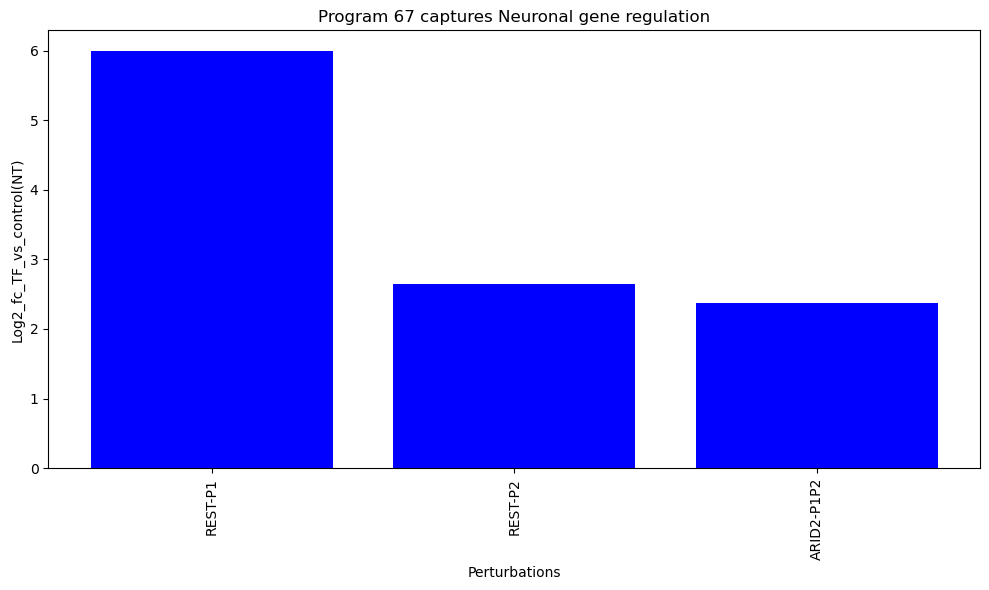

In [37]:
K_250[K_250["Gene"].str.startswith("RES")]
sig_67 = K_250[K_250["Score Column"]=="Usage_67"]
sig_67 = sig_67.sort_values(by = "Log2 Fold Change",ascending=False)
sig_67 = sig_67.iloc[:3,:]

import matplotlib.pyplot as plt

# Assuming sig_67 is your DataFrame
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(sig_67['Gene'], sig_67['Log2 Fold Change'], color='b')

# Add labels and title
plt.xlabel('Perturbations')
plt.ylabel('Log2_fc_TF_vs_control(NT)')
plt.title('Program 67 captures Neuronal gene regulation')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Tight layout for better spacing
plt.tight_layout()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_67_perturbations_Neuronal_program.pdf")

# Show the plot
plt.show()


## Gene ontology for K ==250

In [38]:
GO_250 = enrichment_results[250]
GO_250['neg_log10_p_value'] = -np.log10(GO_250['Adjusted P-value'])
GO_250 = GO_250[GO_250["Adjusted P-value"]<0.05]
GO_250 = GO_250.sort_values(by = "neg_log10_p_value",ascending=False)

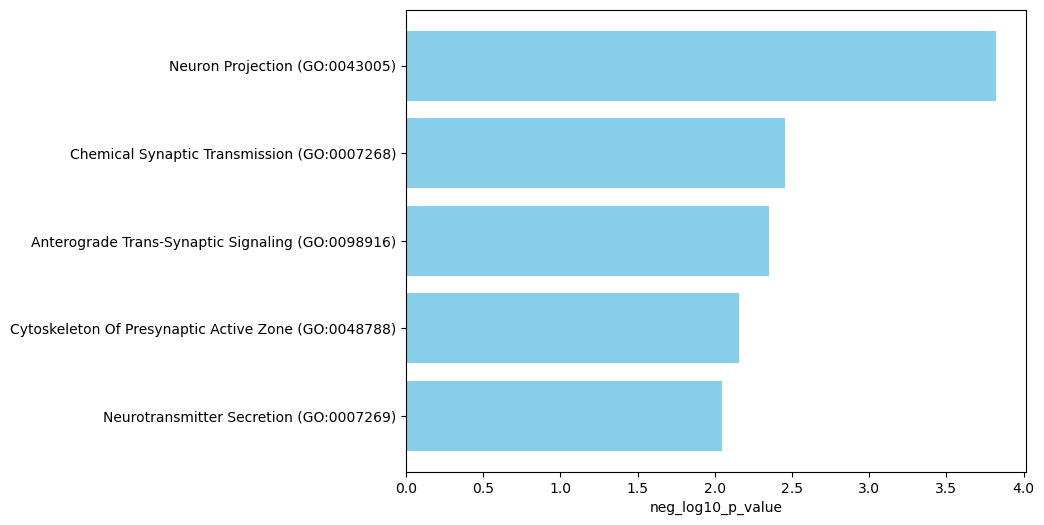

In [39]:
col_67  = GO_250[GO_250["Source"]==67]
col_67 = col_67[col_67["Adjusted P-value"]<0.05]
col_67 = col_67.sort_values(by = "Adjusted P-value")

col_67 = col_67.iloc[:5, :]  # Subset the first 5 rows

plt.figure(figsize=(8, 6))
plt.barh(col_67['Term'], col_67['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')

# Invert the y-axis to reverse the order of bars
plt.gca().invert_yaxis()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_program_67_k_250.pdf")
plt.show()

### mean perturbation score for each TF for K =250

In [28]:
import pickle

# Replace 'your_file.pkl' with the path to your .pkl file
with open('/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/usage_per_perturbation_k_all_targets_clear_gRNA_12_3_24.pkl', 'rb') as file:
    perturbation_score = pickle.load(file)

# Now 'data' contains the content of the pickle file


In [29]:
perturbation_score_250 = perturbation_score['result_k_250']

In [23]:
#rcor2_mean_usage = perturbation_score_250[perturbation_score_250.index.str.startswith("RCOR2")]

## Figure 2 - A

## QC - program count/TF, TF count/program
### No of TFs per program


In [31]:
# Group by 'program' and count unique 'Gene' values for each program number
gene_count_per_program = K_250.groupby('Program')['Gene'].nunique().reset_index()

# Rename the columns for better readability
gene_count_per_program.columns = ['Program', 'Unique Gene Count']



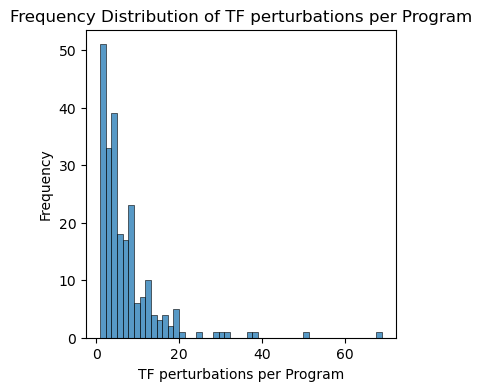

In [32]:
 
plt.figure(figsize=(4, 4))
sns.histplot(gene_count_per_program['Unique Gene Count'], kde=False,  bins=50)

# Add labels and title
plt.xlabel('TF perturbations per Program')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of TF perturbations per Program')
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/Freq_TF_perturbations_per_program_QC.pdf")
plt.show()


In [33]:
gene_count_per_program = gene_count_per_program.sort_values(by = "Unique Gene Count",ascending=False)

In [34]:
gene_count_per_program["Unique Gene Count"].mean()
gene_count_per_program["Unique Gene Count"].median()

np.float64(5.0)

## Number of programs per TF

In [35]:
# Group by 'Gene' and count unique 'Program' values for each gene
program_count_per_gene = K_250.groupby('Gene')['Program'].nunique().reset_index()

# Rename the columns for clarity
program_count_per_gene.columns = ['Gene', 'Program Count']

In [36]:
program_count_per_gene =  program_count_per_gene.sort_values(by = "Program Count",ascending=True)

In [37]:
program_count_per_gene["Program Count"].mean(),program_count_per_gene["Program Count"].median()

(np.float64(6.904564315352697), np.float64(2.0))

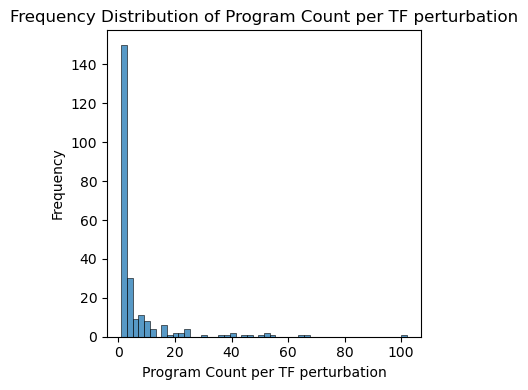

In [38]:
# Plot the histogram with discrete bins and KDE curve
plt.figure(figsize=(4, 4))
sns.histplot(program_count_per_gene['Program Count'], kde=False, bins=50)

# Add labels and title
plt.xlabel('Program Count per TF perturbation')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Program Count per TF perturbation')

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/Freq_program_count_per_TF_QC.pdf")


# Display the plot
plt.tight_layout()
plt.show()

## Gene ontology heatmap

In [136]:
source = [1,28,12,13,67]
program_for_heatmap = GO_250[GO_250["Source"].isin(source)]
program_for_heatmap_sorted = program_for_heatmap.sort_values(by='neg_log10_p_value', ascending=False)
# Step 2: Create a pivot table for the heatmap with all terms
heatmap_data = program_for_heatmap_sorted.pivot(index='Term', columns='Source', values='neg_log10_p_value')

# Ensure column order matches `Source` values
heatmap_data = heatmap_data.reindex(columns=program_for_heatmap['Source'].unique())

# Step 3: Order rows based on column values (you can change the sorting criteria if needed)
heatmap_data = heatmap_data.sort_values(by=heatmap_data.columns.tolist(), ascending=False)




program_for_heatmap_filtered = program_for_heatmap


cap_value = 3  # Cap at -log10(0.001), which corresponds to a p-value of 0.001
program_for_heatmap_filtered['neg_log10_p_value'] = program_for_heatmap_filtered['neg_log10_p_value'].clip(upper=cap_value)

# Step 4: Sort the data by neg_log10_p_value (you can remove the top 5 filtering)
program_for_heatmap_sorted = program_for_heatmap_filtered.sort_values(by='neg_log10_p_value', ascending=False)

# Step 5: Create a pivot table for the heatmap with all terms
heatmap_data = program_for_heatmap_sorted.pivot(index='Term', columns='Source', values='neg_log10_p_value')

# Step 6: Handle NaN values (you can replace NaN with a specific value or leave them as NaN)
# Here, we'll fill NaN values with a specific value and display them as a distinct color
heatmap_data = heatmap_data.fillna(np.nan)  # Use np.nan to keep NaNs as they are

# Ensure column order matches `Source` values
heatmap_data = heatmap_data.reindex(columns=program_for_heatmap['Source'].unique())

heatmap_data = heatmap_data[source]


/tmp/ipykernel_2607/1207902361.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  program_for_heatmap_filtered['neg_log10_p_value'] = program_for_heatmap_filtered['neg_log10_p_value'].clip(upper=cap_value)



## Figure 2 -B

In [137]:
from matplotlib.colors import LinearSegmentedColormap
# Step 6: Create a mask for NaN values
mask = np.isnan(heatmap_data)

# Step 7: Replace NaNs with a placeholder value (we'll use zero for clustering)
# This value will be ignored in clustering, but still show as gray in the heatmap.
heatmap_data_for_clustering = heatmap_data.copy()
heatmap_data_for_clustering = heatmap_data_for_clustering.fillna(0)


In [138]:
# Step 1: Filter rows where column "67" has a value other than 0
#rows_to_label = heatmap_data_for_clustering[heatmap_data_for_clustering[67] != 0].index.tolist()

rows_to_label = ['Chemical Synaptic Transmission (GO:0007268)', 'Neuron To Neuron Synapse (GO:0098984)','Cardiac Muscle Cell Development (GO:0055013)','Regulation Of Heart Contraction (GO:0008016)','Embryonic Heart Tube Morphogenesis (GO:0003143)','Adult Heart Development (GO:0007512)',
                'Glucose Metabolic Process (GO:0006006)','Carbohydrate Catabolic Process (GO:0016052)',
                 'Collagen-Containing Extracellular Matrix (GO:0062023)','Collagen Fibril Organization (GO:0030199)']
# Step 2: Get the indices of these rows in the DataFrame
row_indices = [heatmap_data_for_clustering.index.get_loc(row) for row in rows_to_label]


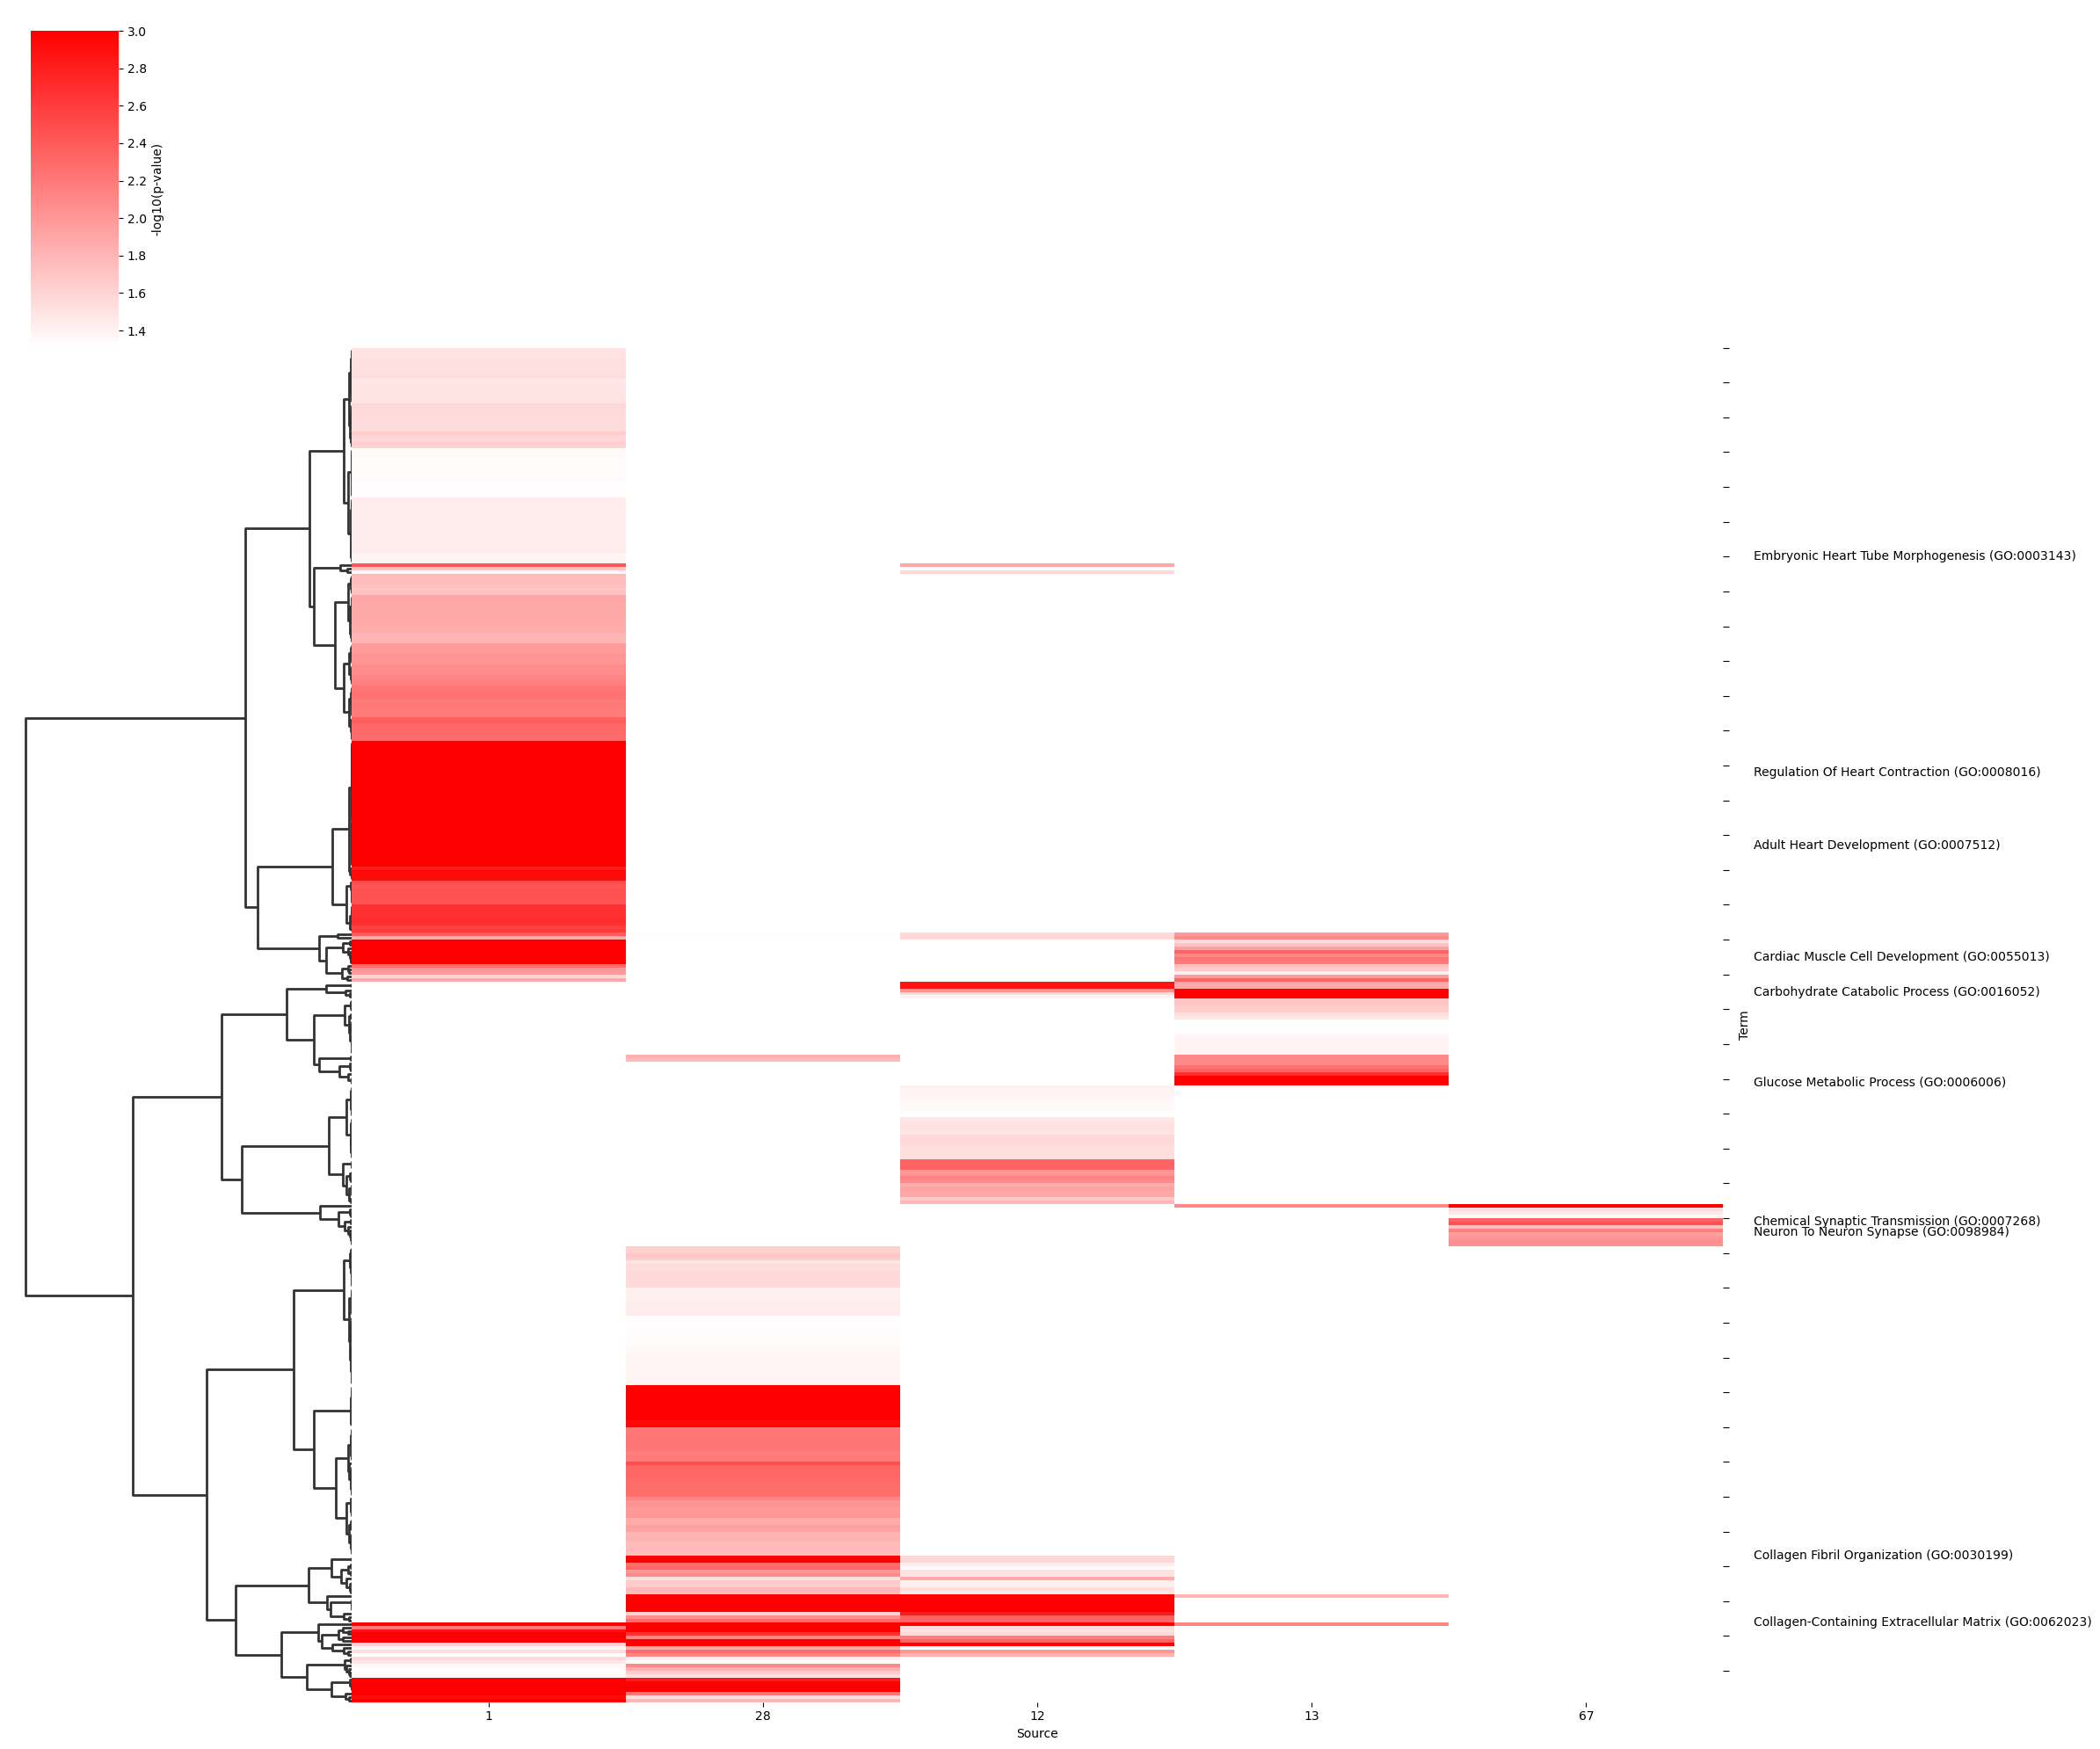

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Filter rows where column "67" has a value other than 0
#rows_to_label = heatmap_data_for_clustering[heatmap_data_for_clustering[67] != 0].index.tolist()




# Step 1: Filter rows where column "67" has a value other than 0
#rows_to_label = heatmap_data_for_clustering[heatmap_data_for_clustering[67] != 0].index.tolist()

red_cmap = LinearSegmentedColormap.from_list("RedGradient", ["white", "red"])



# Step 2: Create the cluster map with row clustering enabled
cluster = sns.clustermap(
    heatmap_data_for_clustering,
    row_cluster=True,  # Row clustering enabled
    col_cluster=False, # Column clustering disabled
    cmap=red_cmap,
    annot=False,
    cbar_kws={'label': '-log10(p-value)'},
    figsize=(20, 20),
    method='ward',
    metric='euclidean',
    tree_kws={"linewidths": 2},
    mask=mask,           # Ensure mask is defined earlier
    yticklabels=False    # Turn off default row labels
)

# Step 3: Get the new row order after clustering
reordered_indices = cluster.dendrogram_row.reordered_ind
reordered_labels = heatmap_data_for_clustering.index[reordered_indices]

# Step 4: Filter rows for labeling
filtered_rows_to_label = [label for label in rows_to_label if label in reordered_labels]
row_indices = [reordered_labels.get_loc(label) for label in filtered_rows_to_label]

# Step 5: Add tick marks at regular intervals
ax = cluster.ax_heatmap
num_rows = len(reordered_labels)
tick_positions = np.arange(0, num_rows, 10)  # Place a tick every 10 rows
ax.set_yticks(tick_positions)
ax.tick_params(axis='y', direction='out', length=5, color='black')

# Step 6: Add connecting lines and labels only for specific rows
offset_x = 0.01  # Distance of label from heatmap
line_length = 1.0  # Length of connecting line

for idx in row_indices:
    x_start = heatmap_data_for_clustering.shape[1]  # Edge of heatmap
    x_end = x_start + offset_x
    y_position = idx

    # Add line from heatmap edge to the label
    ax.plot(
        [x_start, x_end],  # x-coordinates
        [y_position, y_position],  # y-coordinates
        color='black',
        lw=0.5
    )
    
    # Add label at the end of the line
    ax.text(
        x_end + 0.1, y_position, reordered_labels[idx],
        ha='left', va='center', fontsize=10, color='black',
        bbox=dict(facecolor='white', alpha=0)
        
    )

#plt.savefig('/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_figure_2_heatmap_with_labels.pdf', bbox_inches='tight', dpi=300)

# Step 7: Display the plot
plt.show()


## Perturbations associated with a program

## Figure 2 C

### Differentiation program

### Mature differentiation program
### Identifying mature cardiac programs and associated perturbations in a systematic way

In [44]:
# List of keywords related to heart
cardiac_keywords = ['Cardiac', 'Heart', 'contraction','Ventricular']

# Function to check if a term contains any of the metabolism-related keywords as a substring
def contains_cardiac(term):
    # Convert term to lowercase and check if any of the keywords appear as substrings
    return any(keyword.lower() in term.lower() for keyword in cardiac_keywords)

# Sort by 'neg_log10_p_value' within each 'Source', descending order
GO_250_sorted = GO_250.sort_values(by=['Source', 'neg_log10_p_value'], ascending=[True, False])

# Get the top 10 rows per 'Source'
top_10_per_source = GO_250_sorted.groupby('Source').head(10)

# Add a new column to indicate if the term is related to metabolism
top_10_per_source['cardiac_related'] = top_10_per_source['Term'].apply(contains_cardiac)
cardiac_programs = top_10_per_source[top_10_per_source["cardiac_related"]==True]

/tmp/ipykernel_2607/3457267384.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_per_source['cardiac_related'] = top_10_per_source['Term'].apply(contains_cardiac)


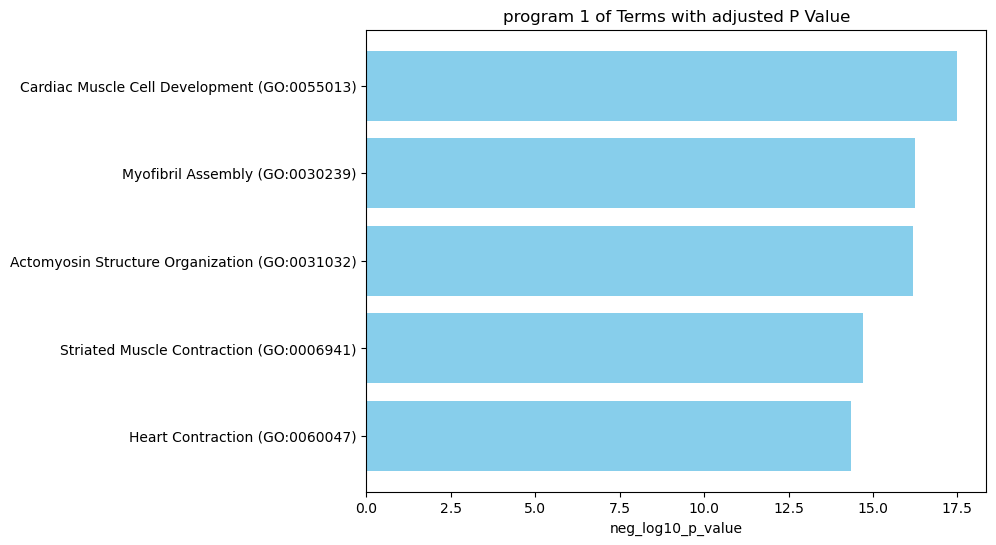

In [45]:
GO_col1 = GO_250[GO_250["Source"]==1]
GO_col1 = GO_col1[GO_col1["Adjusted P-value"]<0.05]
GO_col1 = GO_col1.sort_values(by = "neg_log10_p_value",ascending=False)
GO_col1 = GO_col1.iloc[:5,:]


plt.figure(figsize=(8, 6))
plt.barh(GO_col1['Term'], GO_col1['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 1 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_prog_1_k_250_mature_cardiac_program.pdf")

#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()


## 3 programs were identified with program 1 covering the entire axis of differentiation perturbations that were recovered from smaller K

In [46]:
prog_1_pert = K_250[K_250["Program"]==1]
pd.set_option('display.max_colwidth', None)
prog_1_pert = prog_1_pert.sort_values(by = "Log2 Fold Change")
#prog_1_pert.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program1_TF_full_mature_cardiac_1_10_25.csv")

In [47]:
prog_2_pert = K_250[K_250["Program"]==2]
prog_2_pert = prog_2_pert.sort_values(by = "Log2 Fold Change")

prog_50_pert = K_250[K_250["Program"]==50]
prog_50_pert = prog_2_pert.sort_values(by = "Log2 Fold Change")

### Cluster overlap with known CHD genes from Australian database

In [48]:
Aus_disease = pd.read_csv("/project/GCRB/Hon_lab/s438217/cNMF/chdgene_table_AU.csv")
CHD_list = Aus_disease["Gene"].to_list()
top_genes_250 = top_genes_dict[250]
results = []
for column in top_genes_250.columns:
    # Count the number of overlapping elements
    overlap_count = top_genes_250[column].isin(CHD_list).sum()
    # Get the actual overlapping genes
    overlapped_genes = top_genes_250[column][top_genes_250[column].isin(CHD_list)].tolist()
    # Append the result as a tuple (column name, count, list of overlapping genes)
    results.append((column, overlap_count, overlapped_genes))

# Create a new DataFrame from the results
overlap_df = pd.DataFrame(results, columns=['Column Name', 'Count', 'Overlapped Genes'])
overlap_df = overlap_df.sort_values(by = "Count",ascending=False)


In [49]:
n_CHD =  len(set(CHD_list))# Unique genes in CHD
chd_df = K_250[K_250['Gene'].str.startswith(tuple(CHD_list))]

In [50]:
from scipy.stats import hypergeom
import pandas as pd

# Total universe of genes
all_genes = set(top_genes_250.stack().dropna())

# N is the number of unique genes
N = len(all_genes)

# Convert the gene list to a set
gene_set = set(CHD_list)
K = len(gene_set)  # Size of the gene set
threshold = 0.05

# Initialize a list to store results
significant_CHD = []

# Loop through each column
for column in top_genes_250.columns:
    # Drop NaN values and convert to set
    column_genes = set(top_genes_250[column].dropna())
    n = len(column_genes)  # Number of genes in the column
    
    # Calculate the overlap
    overlap_genes = column_genes & gene_set
    k = len(overlap_genes)
    
    # Perform hypergeometric test
    p_value = hypergeom.sf(k - 1, N, K, n)  # Survival function for overlap
    
    # Check for significance
    if p_value < threshold:
        significant_CHD.append({
            "Column": column,
            "Overlap": k,
            "P-value": p_value,
            "Overlapping Genes": list(overlap_genes)  # Add overlapping genes
        })

# Convert significant columns to a DataFrame
significant_CHD_df = pd.DataFrame(significant_CHD)

significant_CHD_df['adj_p_value'] = multipletests(significant_CHD_df['P-value'], method='fdr_bh')[1]
significant_CHD_df = significant_CHD_df[significant_CHD_df["adj_p_value"]<0.05]
significant_CHD_df = significant_CHD_df.sort_values(by = "adj_p_value")



GO_CHD = GO_250[GO_250["Source"].isin(significant_CHD_df["Column"])]
GO_CHD = GO_CHD[GO_CHD["Adjusted P-value"]<0.05]

final_CHD_df = significant_CHD_df[significant_CHD_df["Column"].isin(GO_CHD["Source"])]
final_CHD_df.rename(columns={"Column": "Program"}, inplace=True)

pd.set_option('display.max_colwidth', None)

final_CHD_df

/tmp/ipykernel_2607/4188825566.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_CHD_df.rename(columns={"Column": "Program"}, inplace=True)


,Program,Overlap,P-value,Overlapping Genes,adj_p_value
2,5,14,1.643646e-09,"[GATA6, PRKD1, GATA5, FBN1, JAG1, ZFPM2, TBX5, SMARCB1, GPC3, ZEB2, MEIS2, SMAD6, GATA4, HAND2]",3.780387e-08
0,1,12,1.362282e-07,"[NKX2-5, TAB2, MYH6, TBX20, MYBPC3, FOXP1, MEIS2, ACTC1, CITED2, KDM6A, KDR, MYH7]",1.566625e-06
6,10,9,5.161361e-05,"[GATA6, SF3B4, RAD21, GATA5, MED13L, JAG1, RAF1, GATA4, CITED2]",2.967783e-04
11,28,8,3.018274e-04,"[FBN1, HAND1, ZEB2, FOXC2, GPC3, PRDM6, TGFBR1, BMPR2]",1.388406e-03
1,2,7,1.560797e-03,"[HAND1, NKX2-5, MYH6, MYBPC3, FOXP1, KDM6A, KDR]",3.988703e-03
16,96,7,1.560797e-03,"[FBN1, ZFPM2, KMT2A, NPHP3, SMAD6, PIGV, EVC2]",3.988703e-03
8,13,6,7.043883e-03,"[MYH6, MEIS2, FGFR2, ACTC1, SMAD2, PBX1]",1.246225e-02
14,32,6,7.043883e-03,"[FBN1, DOCK6, TGFBR2, FOXC2, FLT4, KDR]",1.246225e-02
5,9,5,2.729338e-02,"[JAG1, HAND1, PITX2, ZEB2, HAND2]",2.729338e-02
13,31,5,2.729338e-02,"[MYH6, ACTC1, KDM6A, KDR, FLNA]",2.729338e-02


#### top 4 terms were considered 
#### program 5 and 10 had generic transcription terms, not related to heart biology

## Program 1 and 28 were significantly enriched for CHD genes
##  Perturbations and Gene ontology for program 1 and 28

## Program 1 covered the entire axis of perturbation associated with mature cardiac program

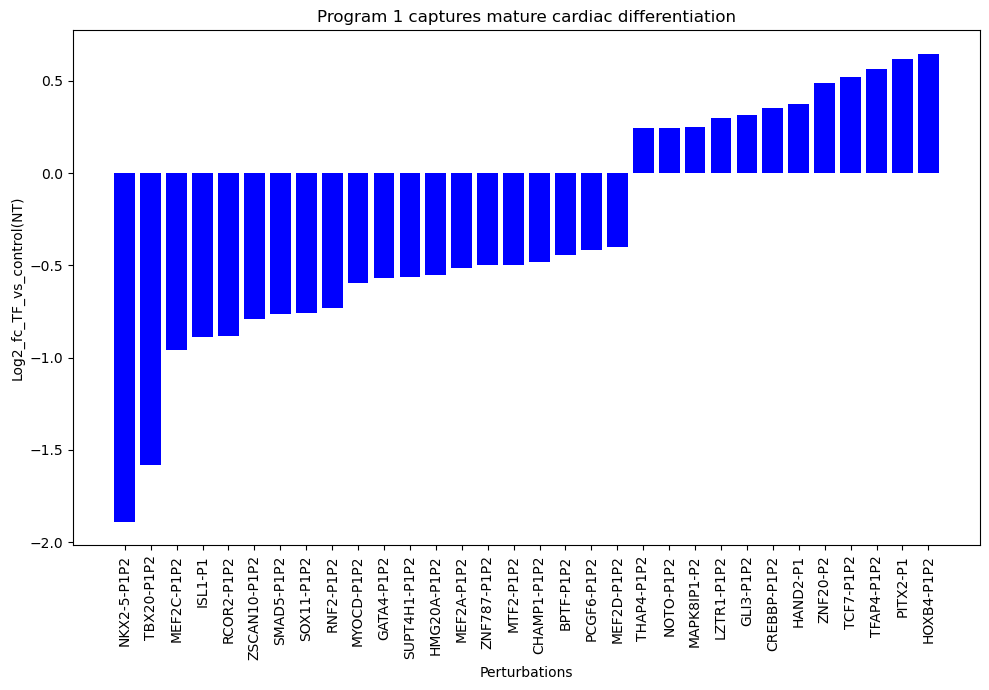

In [51]:
# Top 10 rows
top_10 = prog_1_pert.head(20)

# Middle 10 rows
middle_start = len(prog_1_pert) // 2 - 5  # Start index for middle 10
middle_end = middle_start + 3  # End index for middle 10
middle_10 = prog_1_pert.iloc[middle_start:middle_end]

# Bottom 10 rows
bottom_10 = prog_1_pert.tail(5)

included_genes = prog_1_pert[prog_1_pert["Gene"].isin(chd_df["Gene"])]

# Combine top, middle, bottom rows with included genes
final_selection = pd.concat([top_10, middle_10, bottom_10, included_genes])

# Drop duplicates (in case genes in gene_list are already in top, middle, or bottom)
final_selection = final_selection.drop_duplicates(subset=["Gene"])
final_selection = final_selection.sort_values("Log2 Fold Change")

prog1_plot = pd.concat([top_10,middle_10,bottom_10])

import matplotlib.pyplot as plt

# Assuming sig_67 is your DataFrame
plt.figure(figsize=(10, 7))

# Create a bar plot
plt.bar(final_selection['Gene'], final_selection['Log2 Fold Change'], color='b')

# Add labels and title
plt.xlabel('Perturbations')
plt.ylabel('Log2_fc_TF_vs_control(NT)')
plt.title('Program 1 captures mature cardiac differentiation')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Tight layout for better spacing
plt.tight_layout()

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_1_perturbations_mature_cardiac_program.pdf")
# Show the plot
plt.show()


In [52]:
prog_28_pert = K_250[K_250["Program"]==28]
pd.set_option('display.max_colwidth', None)
prog_28_pert = prog_28_pert.sort_values(by = "Log2 Fold Change")




#prog_28_pert.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program28_TF_full_cellular_matrix_10_25.csv")

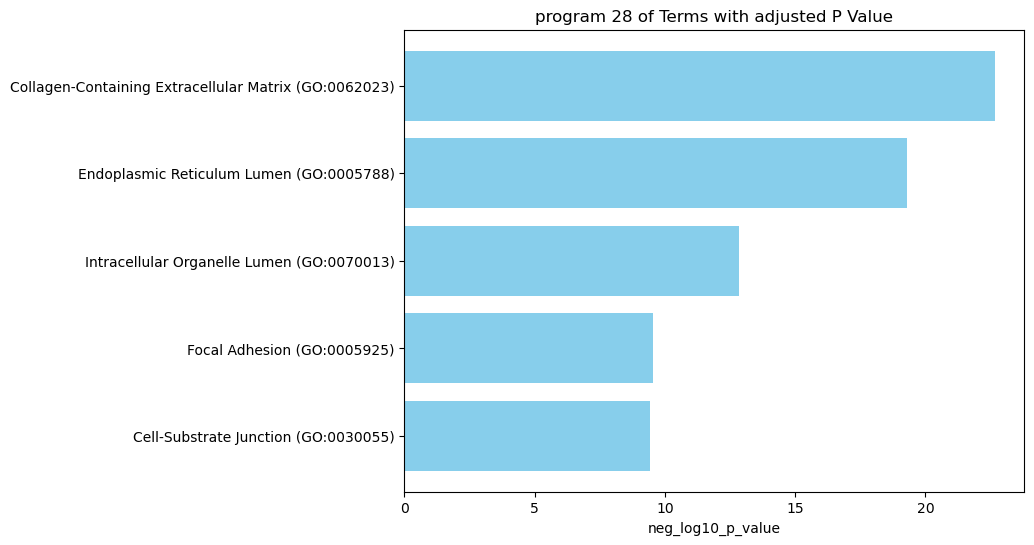

In [53]:
GO_col28 = GO_250[GO_250["Source"]==28]
GO_col28 = GO_col28[GO_col28["Adjusted P-value"]<0.05]
GO_col28 = GO_col28.sort_values(by = "neg_log10_p_value",ascending=False)
GO_col28 = GO_col28.iloc[:5,:]






plt.figure(figsize=(8, 6))
plt.barh(GO_col28['Term'], GO_col28['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 28 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()

### Cluster 2 and Cluster 7 from energy distance analysis

In [54]:
cluster_7 = ['CHAMP1', 'GTF2I', 'ISL1', 'MEF2A', 'MEF2C']

In [55]:
cluster_2 = ['AFF4',
 'ARID2',
 'CHD7',
 'CNBP',
 'DNAJC19',
 'HMG20A',
 'KLF12',
 'MAFB',
 'MBD6',
 'RARA',
 'SMAD2',
 'SMAD3',
 'SMAD4',
 'SOX4',
 'SUPT4H1',
 'TBX5',
 'TCEB3',
 'YWHAE',
 'ZBTB12',
 'ZC3H15',
 'ZFPM2',
 'ZIC2',
 'ZNF384']

In [56]:
clust2 = K_250[K_250['Gene'].str.startswith(tuple(cluster_2))]
clust7 = K_250[K_250['Gene'].str.startswith(tuple(cluster_7))]


In [57]:
from scipy.stats import hypergeom
import pandas as pd

# Unique gene counts
M = K_250['Gene'].nunique()  # Total unique genes in K_250
N_clust2 = clust2['Gene'].nunique()  # Unique genes in clust2
N_clust7 = clust7['Gene'].nunique()  # Unique genes in clust7

# Initialize a list to store results
results = []

# Iterate through each unique program in K_250
for program in K_250['Program'].unique():
    # Genes in this program
    program_genes = K_250[K_250['Program'] == program]['Gene']
    n = program_genes.nunique()  # Total genes in this program

    # Overlaps with clust2
    overlap_clust2 = clust2[clust2['Program'] == program]['Gene'].nunique()
    
    # Overlaps with clust7
    overlap_clust7 = clust7[clust7['Program'] == program]['Gene'].nunique()

    # Hypergeometric p-values
    p_value_clust2 = hypergeom.sf(overlap_clust2 - 1, M, N_clust2, n)
    p_value_clust7 = hypergeom.sf(overlap_clust7 - 1, M, N_clust7, n)

    # Append results
    results.append({
        'Program': program,
        'Total_Genes': n,
        'Cluster_2_Overlap': overlap_clust2,
        'P-value_Cluster_2': p_value_clust2,
        'Cluster_7_Overlap': overlap_clust7,
        'P-value_Cluster_7': p_value_clust7
    })

# Convert results to DataFrame
clust_2_clust_7_pval = pd.DataFrame(results)



In [58]:
clust_2_clust_7_pval.sort_values(by = "P-value_Cluster_7")

,Program,Total_Genes,Cluster_2_Overlap,P-value_Cluster_2,Cluster_7_Overlap,P-value_Cluster_7
174,183,4,0,1.000000,3,0.000017
216,28,19,4,0.059256,4,0.000134
13,8,21,2,0.539370,4,0.000206
30,216,2,0,1.000000,2,0.000346
12,214,2,0,1.000000,2,0.000346
...,...,...,...,...,...,...
95,157,6,1,0.408758,0,1.000000
94,32,9,1,0.547772,0,1.000000
93,20,6,1,0.408758,0,1.000000
87,93,6,0,1.000000,0,1.000000


In [59]:
from statsmodels.stats.multitest import multipletests

# Adjust p-values for multiple testing
clust_2_clust_7_pval['Adj_P-value_Cluster_2'] = multipletests(clust_2_clust_7_pval['P-value_Cluster_2'], method='fdr_bh')[1]
clust_2_clust_7_pval['Adj_P-value_Cluster_7'] = multipletests(clust_2_clust_7_pval['P-value_Cluster_7'], method='fdr_bh')[1]


In [60]:
clust_2_clust_7_pval = clust_2_clust_7_pval[['Program', 'Total_Genes', 'Cluster_2_Overlap', 'P-value_Cluster_2', 'Adj_P-value_Cluster_2',
                       'Cluster_7_Overlap', 'P-value_Cluster_7', 'Adj_P-value_Cluster_7']]


## Program 12 for cluster 2

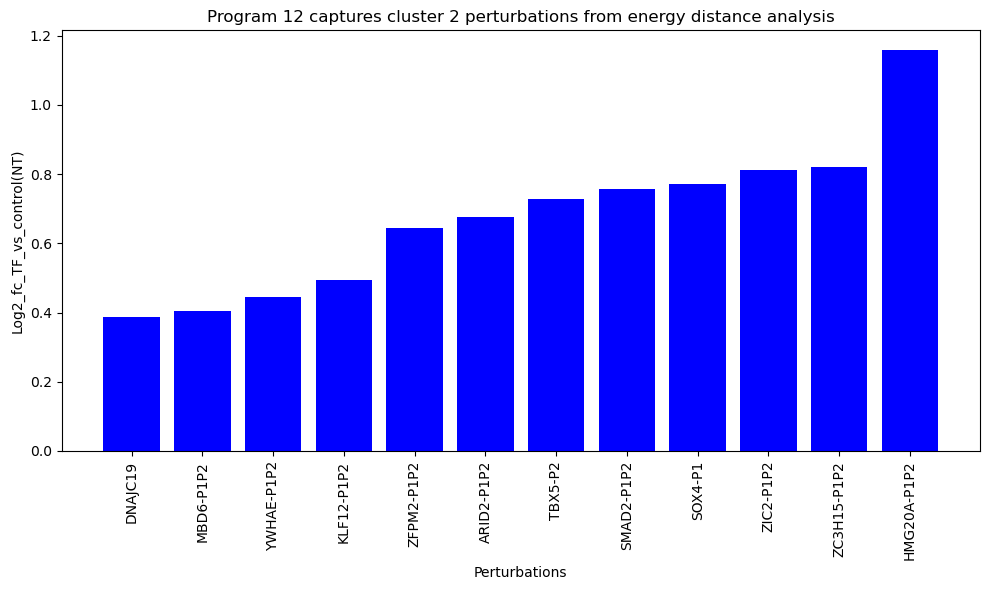

In [61]:
prog12_clust2 = clust2[clust2["Program"]==12]
prog12 = K_250[K_250["Program"]==12]
prog12_clust2 = prog12_clust2.sort_values(by = "Log2 Fold Change")


import matplotlib.pyplot as plt

# Assuming sig_67 is your DataFrame
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(prog12_clust2['Gene'], prog12_clust2['Log2 Fold Change'], color='b')

# Add labels and title
plt.xlabel('Perturbations')
plt.ylabel('Log2_fc_TF_vs_control(NT)')
plt.title('Program 12 captures cluster 2 perturbations from energy distance analysis')

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_12_perturbations_cluster_2_energy_distance.pdf")

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [62]:
program_12 = GO_250[GO_250["Source"]==12]
program_12 = program_12[program_12["Adjusted P-value"]<0.05]
program_12 = program_12.sort_values(by = "neg_log10_p_value",ascending=False)

program_12 = program_12.iloc[:5,:]


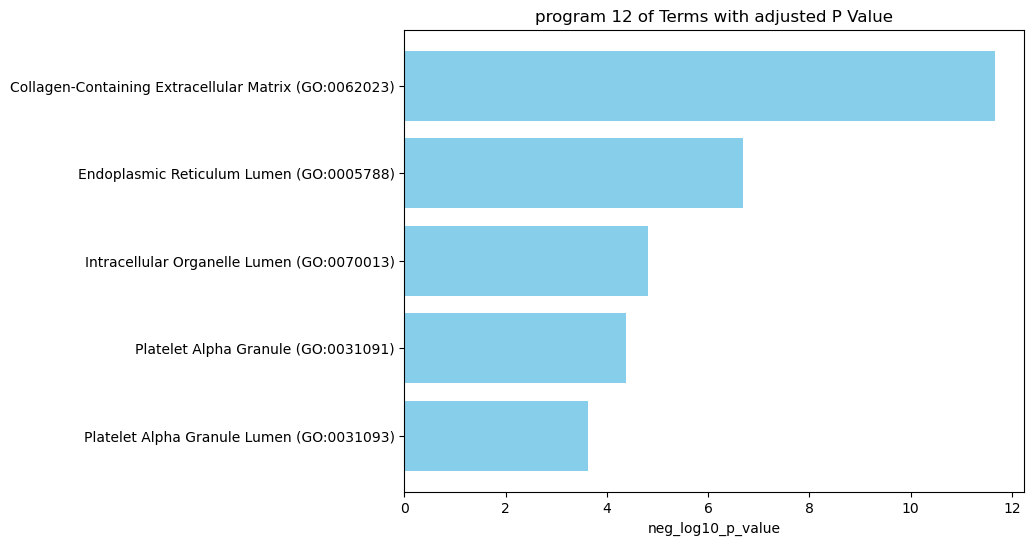

In [63]:

plt.figure(figsize=(8, 6))
plt.barh(program_12['Term'], program_12['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 12 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_prog_12_terms_cluster_2_energy_distance.pdf")

#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()

In [64]:
clust_2_clust_7_pval = clust_2_clust_7_pval.sort_values(by = "Adj_P-value_Cluster_7")

In [65]:
clust_2_clust_7_pval = clust_2_clust_7_pval[clust_2_clust_7_pval["Adj_P-value_Cluster_7"]<0.05]

In [66]:
## THERE ARE 18 SIGNIFICANT PROGRAMS FOR CLUSTER 7 ENRICHMENT


In [67]:
### empty GO terms programs
## 183,216, 214,173,168,119,235, 225,185
# 167 - Vesicle-Mediated Transport To The Plasma Membrane,Endosomal Transport
## 28,8,17 - collagen matrix etc
## 2- mature cardiac term
## 5 - general transcription term and cardiac term like aortic valve morphogenesis
# metabolic - 13 (glycolysis,Hexose phosphate pathway),14(Aerobic Electron Transport Chain (GO:0019646),Cellular Respiration (GO:0045333),250 (cholesterol,density lipoprotein)


In [68]:
prog13_clust_7 = clust7[clust7["Program"]==13]
prog13_clust_7 = prog13_clust_7.sort_values(by = "Log2 Fold Change")

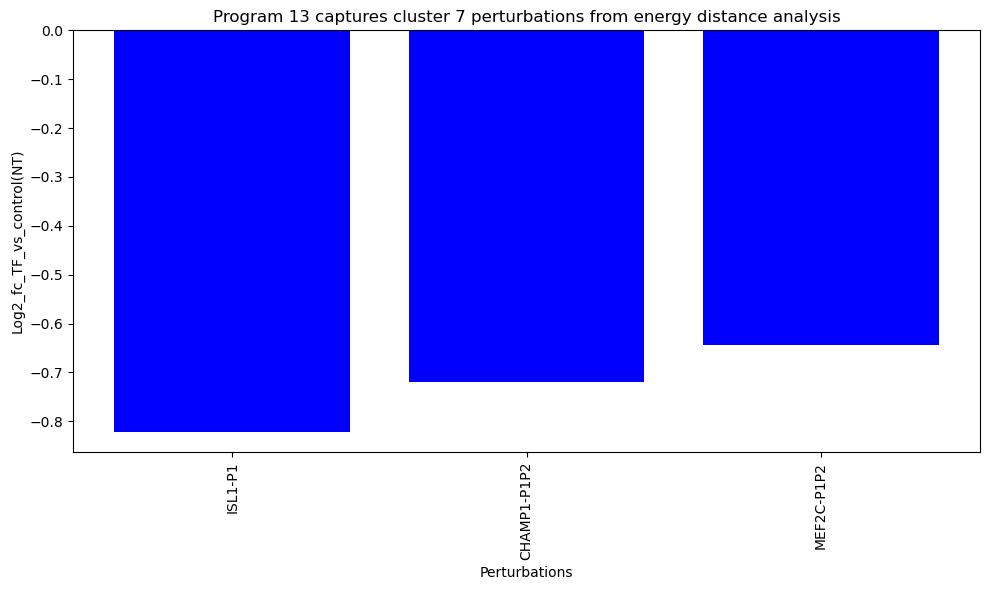

In [69]:
import matplotlib.pyplot as plt

# Assuming sig_67 is your DataFrame
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(prog13_clust_7['Gene'], prog13_clust_7['Log2 Fold Change'], color='b')

# Add labels and title
plt.xlabel('Perturbations')
plt.ylabel('Log2_fc_TF_vs_control(NT)')
plt.title('Program 13 captures cluster 7 perturbations from energy distance analysis')

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_13_perturbations_cluster_7_energy_distance.pdf")

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [70]:
program_13 = GO_250[GO_250["Source"]==13]
program_13 = program_13[program_13["Adjusted P-value"]<0.05]
program_13 = program_13.sort_values(by = "neg_log10_p_value",ascending=False)
program_13 = program_13.iloc[:5,:]

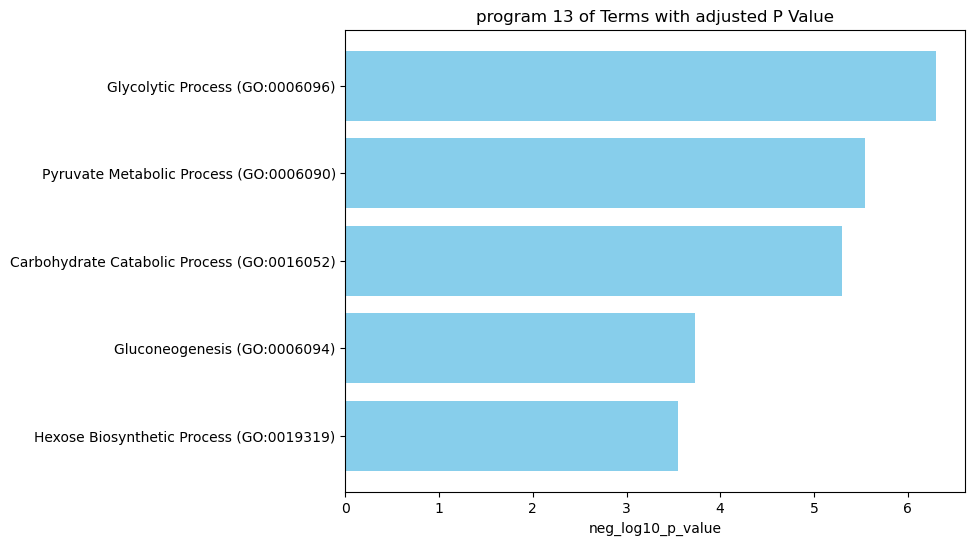

In [71]:

plt.figure(figsize=(8, 6))
plt.barh(program_13['Term'], program_13['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 13 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_prog_13_terms_cluster_7_energy_distance.pdf")


#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()

## Program 14

In [72]:
prog14_clust_7 = clust7[clust7["Program"]==14]
prog14_clust_7 = prog14_clust_7.sort_values(by = "Log2 Fold Change")

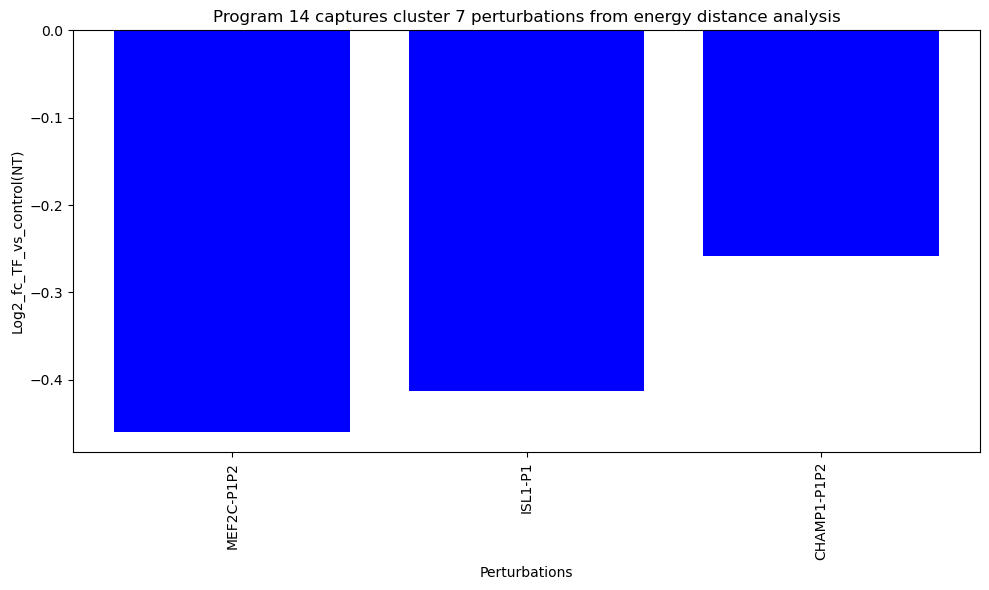

In [73]:
import matplotlib.pyplot as plt

# Assuming sig_67 is your DataFrame
plt.figure(figsize=(10, 6))

# Create a bar plot
plt.bar(prog14_clust_7['Gene'], prog14_clust_7['Log2 Fold Change'], color='b')

# Add labels and title
plt.xlabel('Perturbations')
plt.ylabel('Log2_fc_TF_vs_control(NT)')
plt.title('Program 14 captures cluster 7 perturbations from energy distance analysis')

#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_14_perturbations_cluster_7_energy_distance.pdf")

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [74]:
program_14 = GO_250[GO_250["Source"]==14]
program_14 = program_14[program_14["Adjusted P-value"]<0.05]
program_14 = program_14.sort_values(by = "neg_log10_p_value",ascending=False)
program_14 = program_14.iloc[:5,:]

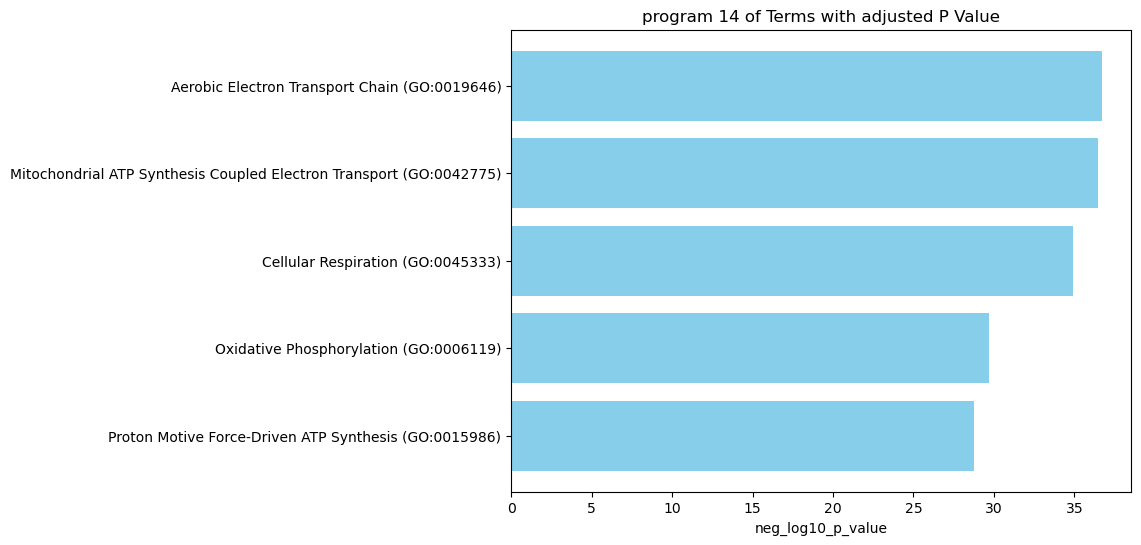

In [75]:

plt.figure(figsize=(8, 6))
plt.barh(program_14['Term'], program_14['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 14 of Terms with adjusted P Value')
plt.gca().invert_yaxis()
#plt.savefig("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/GO_prog_14_terms_cluster_7_energy_distance.pdf")


#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()

In [76]:
program_250 = GO_250[GO_250["Source"]==250]
program_250 = program_250[program_250["Adjusted P-value"]<0.05]
program_250 = program_250.sort_values(by = "neg_log10_p_value",ascending=False)
program_250 = program_250.iloc[:20,:]

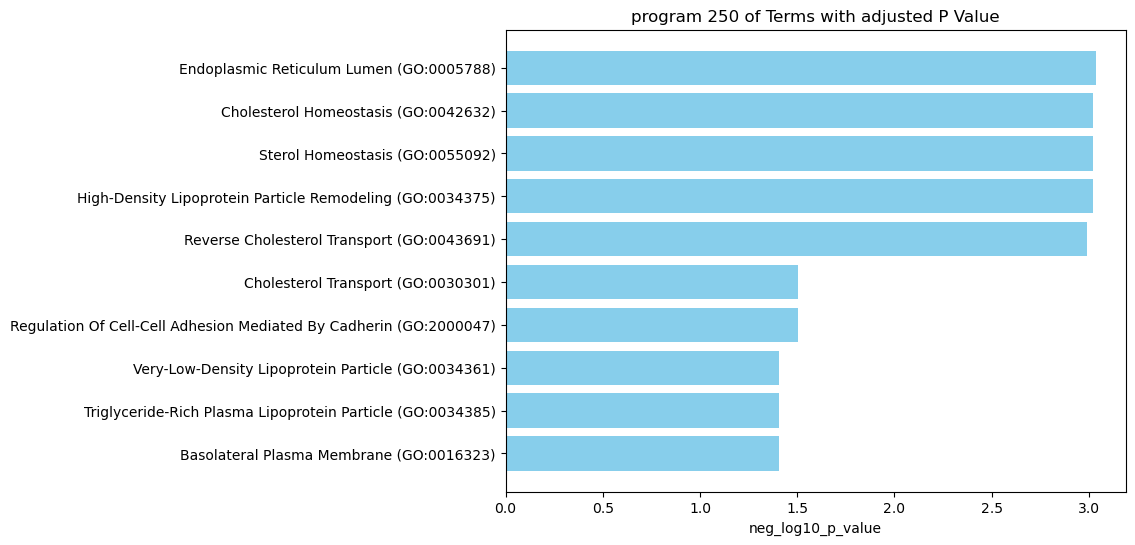

In [79]:

plt.figure(figsize=(8, 6))
plt.barh(program_250['Term'], program_250['neg_log10_p_value'], color='skyblue')
plt.xlabel('neg_log10_p_value')
plt.title('program 250 of Terms with adjusted P Value')
plt.gca().invert_yaxis()

#plt.xlim(0, max(usage_21['Adjusted P Value']) + 0.01)  # Adjust the x limit for better visibility
plt.show()

## Perturbations and gene ontology files for metabolism related programs overlaping with cluster 7

In [78]:
prog13_perturb = K_250[K_250["Program"]==13]
prog13_perturb = prog13_perturb.sort_values(by = "Log2 Fold Change")
prog13_perturb.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_13_perturbations.csv")

prog14_perturb = K_250[K_250["Program"]==14]
prog14_perturb = prog14_perturb.sort_values(by = "Log2 Fold Change")
prog14_perturb.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_14_perturbations.csv")


prog250_perturb = K_250[K_250["Program"]==250]
prog250_perturb = prog250_perturb.sort_values(by = "Log2 Fold Change")
prog250_perturb.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/TF_full_cNMF_figure_2_plots/program_250_perturbations.csv")



GO_terms_13 = GO_250[GO_250["Source"]==13].sort_values(by = "neg_log10_p_value",ascending=False)
GO_terms_13.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/GO_terms_program_13.csv")

GO_terms_14 = GO_250[GO_250["Source"]==14].sort_values(by = "neg_log10_p_value",ascending=False)
GO_terms_14.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/GO_terms_program_14.csv")

GO_terms_250 = GO_250[GO_250["Source"]==250].sort_values(by = "neg_log10_p_value",ascending=False)
GO_terms_250.to_csv("/project/GCRB/Hon_lab/s438217/cNMF/cNMF_output_files/TF_perturb_full/GO_terms_program_250.csv")